### Import libraries

In [108]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,f1_score, recall_score, precision_score,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import tree
import pickle
import torch
import time
from imblearn.over_sampling import SMOTE
#import autosklearn.classification as classifier

In [3]:
print(torch.cuda.is_available())

True


### Load Dataset

In [4]:
df = pd.read_csv("D:/Machine Predictive Maintenance Classification Dataset/data/predictive_maintenance.csv")

In [5]:
df.head(5)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


### Data Profiling

In [6]:
df.shape

(10000, 10)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [8]:
df.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


In [9]:
total_types = df.shape[0]
low_types = df[df["Type"]=="L"].shape[0]
medium_types = df[df["Type"]=="M"].shape[0]
high_types = df[df["Type"]=="H"].shape[0]

# Calculate percentages
low_percentage = (low_types / total_types) * 100
medium_percentage = (medium_types / total_types) * 100
high_percentage = (high_types / total_types) * 100

print(f"Percentage of products with low quality: {low_percentage}%")
print(f"Percentage of products with medium quality: {medium_percentage}%")
print(f"Percentage of products with high quality: {high_percentage}%")

Percentage of products with low quality: 60.0%
Percentage of products with medium quality: 29.970000000000002%
Percentage of products with high quality: 10.03%


In [10]:
df.columns

Index(['UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Target', 'Failure Type'],
      dtype='object')

In [11]:
independent_variables = df.columns[3:8]
independent_variables

Index(['Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]'],
      dtype='object')

In [12]:
dependent_variables = df.columns[8:]
dependent_variables

Index(['Target', 'Failure Type'], dtype='object')

In [13]:
independent_variables[0]

'Air temperature [K]'

In [14]:
df['Target'].unique()

array([0, 1])

In [15]:
df['Failure Type'].unique()

array(['No Failure', 'Power Failure', 'Tool Wear Failure',
       'Overstrain Failure', 'Random Failures',
       'Heat Dissipation Failure'], dtype=object)

In [16]:
for variable in dependent_variables:
    print(df[variable].value_counts())
    print("***"*8)

Target
0    9661
1     339
Name: count, dtype: int64
************************
Failure Type
No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: count, dtype: int64
************************


### Exploratory data analysis

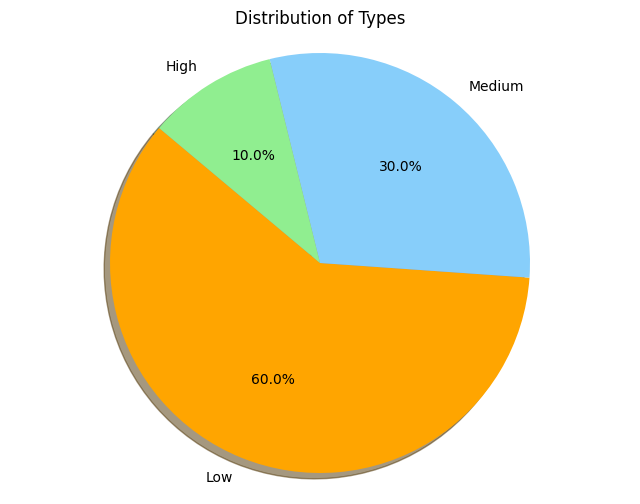

In [17]:
# Data to plot
sizes = [low_percentage, medium_percentage, high_percentage]
labels = ['Low', 'Medium', 'High']
colors = ['orange', 'lightskyblue', 'lightgreen']

# Plot
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Distribution of Types')

plt.show()


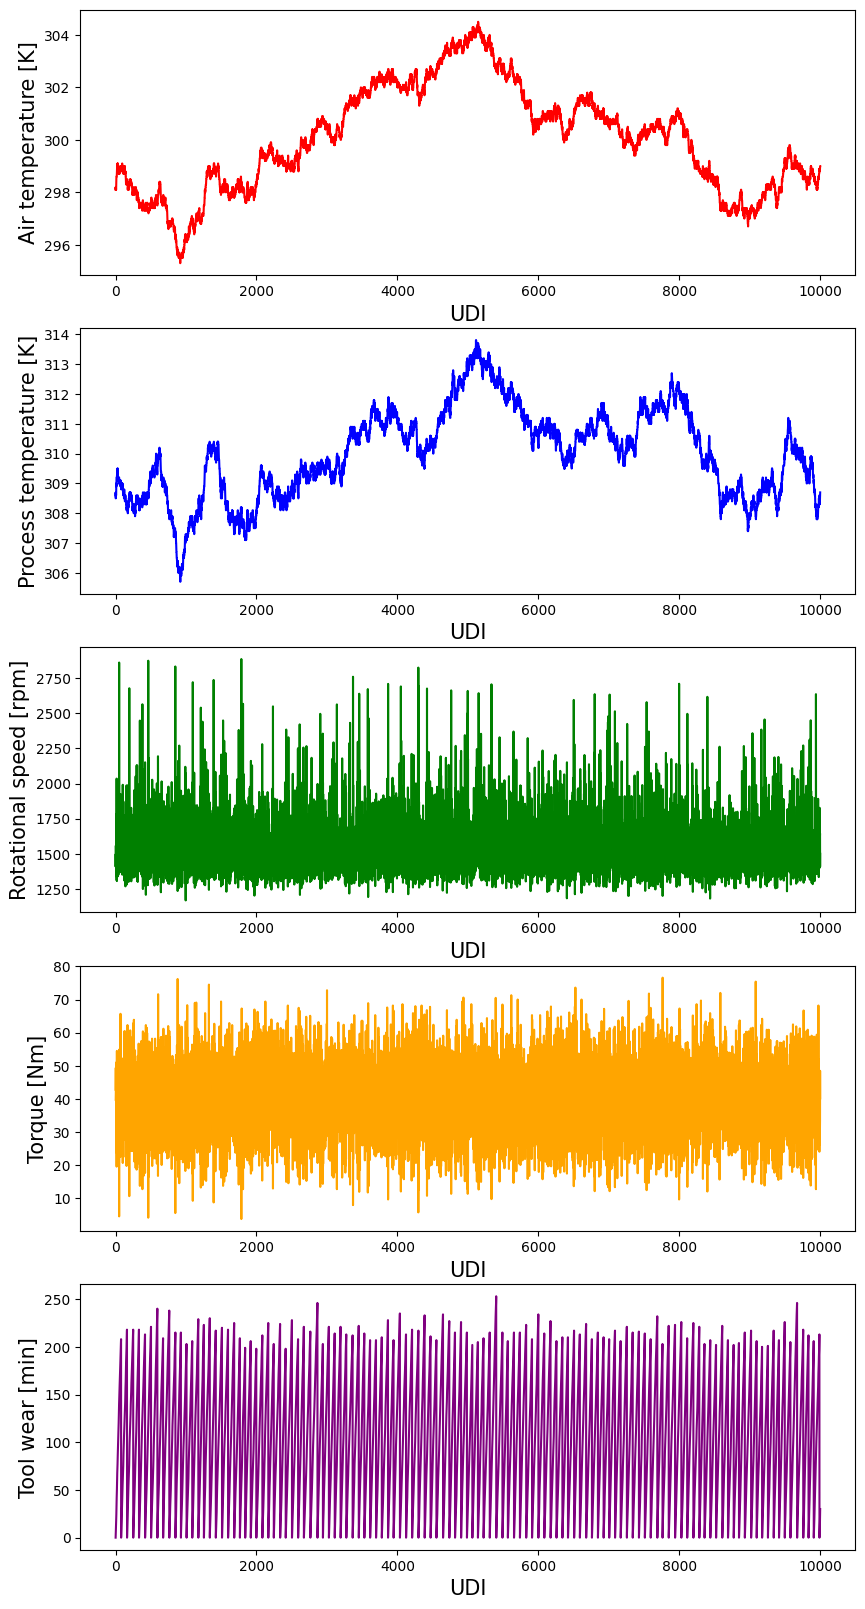

In [18]:
# Visualizing the trends of independent variables
fig, ax = plt.subplots(5,figsize=(10,20))
colors = ['red', 'blue', 'green', 'orange', 'purple']

for i in range(5):
    ax[i].plot(df["UDI"],df[independent_variables[i]],color=colors[i])
    ax[i].set_xlabel("UDI",fontsize=15)
    ax[i].set_ylabel(independent_variables[i],fontsize=15)
    # ax[i].legend(independent_variables[i])
plt.show()

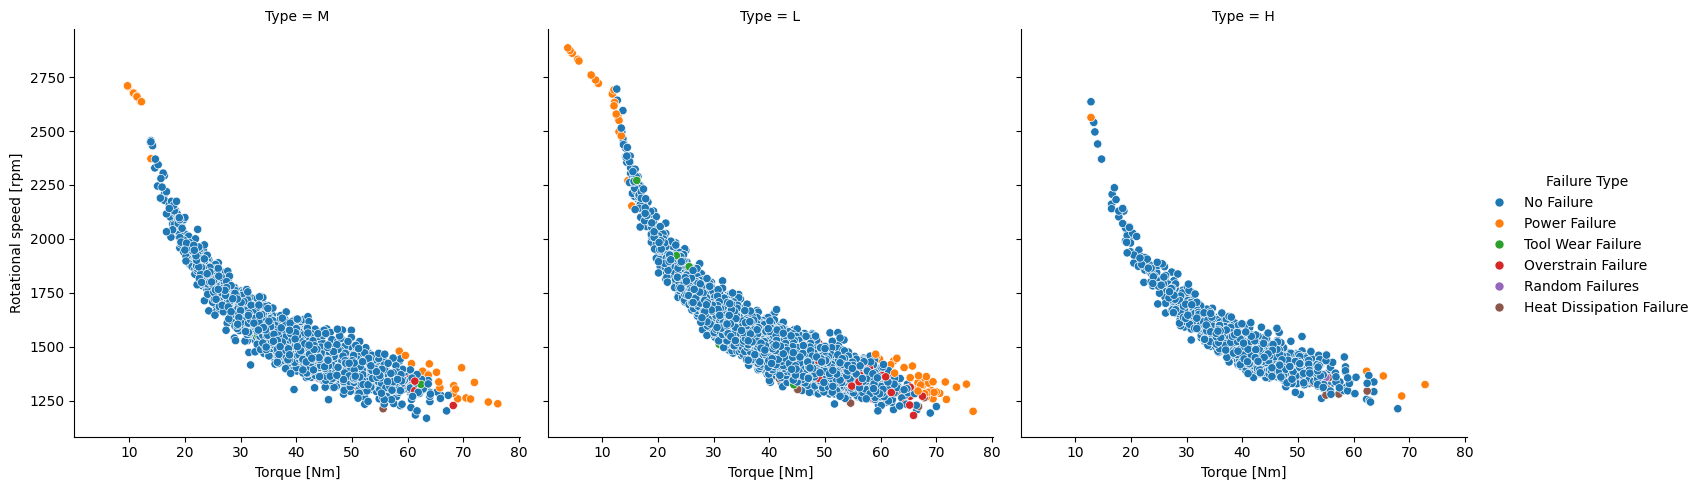

In [19]:
sns.relplot(data=df, x="Torque [Nm]", y="Rotational speed [rpm]", hue="Failure Type", col="Type")

Note that at higher torque we can observe tool waer, overstrain, random and heat dissipation failures. At lower torque we observe power failure.

In [20]:
df

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure
...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,No Failure
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,No Failure
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,No Failure
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,No Failure


In [21]:
independent_variables

Index(['Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]'],
      dtype='object')

In [22]:
df['Air temperature [K]']

0       298.1
1       298.2
2       298.1
3       298.2
4       298.2
        ...  
9995    298.8
9996    298.9
9997    299.0
9998    299.0
9999    299.0
Name: Air temperature [K], Length: 10000, dtype: float64

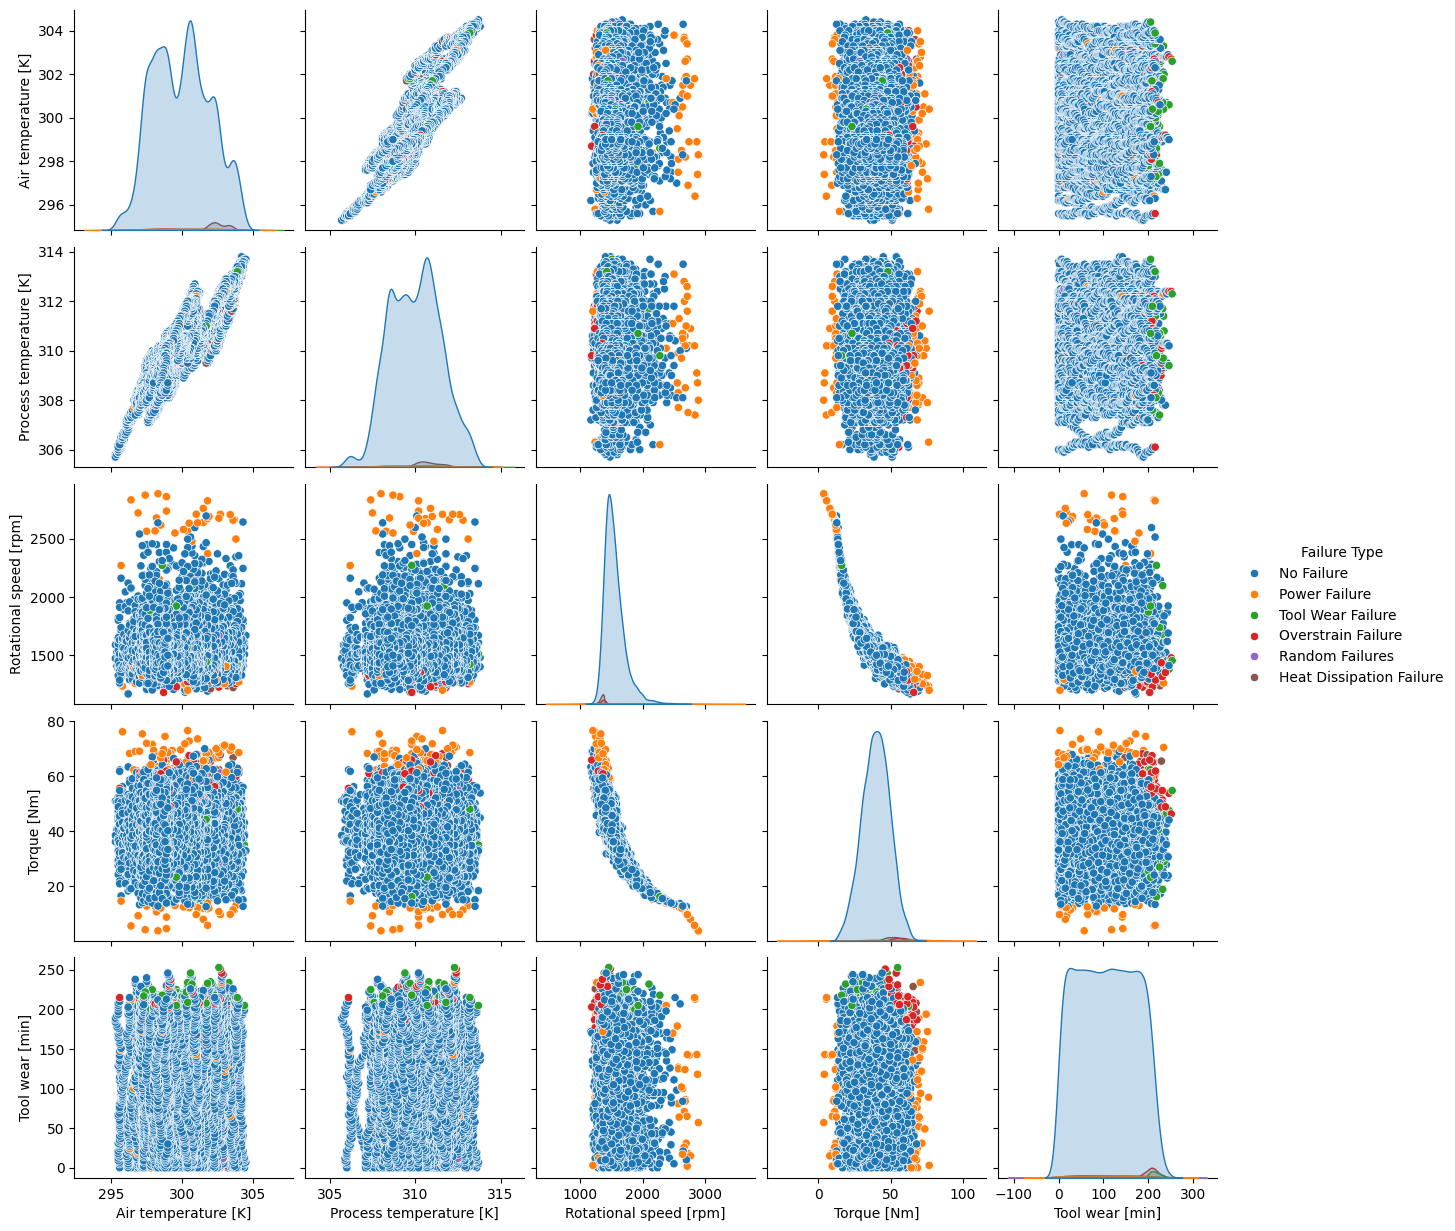

In [23]:
sns.pairplot(df[['Air temperature [K]', 'Process temperature [K]','Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Failure Type']], 
             diag_kind='kde', hue='Failure Type') #it has histograms along the diagonal
                #scatterplots off the diagonal

### Data Preprocessing

In [99]:
new_data = df.copy()
scaler = LabelEncoder()

type_encoder = LabelEncoder()
failure_type_encoder = LabelEncoder()

new_data['Type'] = type_encoder.fit_transform(new_data['Type'])
new_data['EncodedFailureType'] = failure_type_encoder.fit_transform(new_data['Failure Type'])

new_data = new_data.drop(columns=['UDI','Product ID'], axis=1)
new_data

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,EncodedFailureType
0,2,298.1,308.6,1551,42.8,0,0,No Failure,1
1,1,298.2,308.7,1408,46.3,3,0,No Failure,1
2,1,298.1,308.5,1498,49.4,5,0,No Failure,1
3,1,298.2,308.6,1433,39.5,7,0,No Failure,1
4,1,298.2,308.7,1408,40.0,9,0,No Failure,1
...,...,...,...,...,...,...,...,...,...
9995,2,298.8,308.4,1604,29.5,14,0,No Failure,1
9996,0,298.9,308.4,1632,31.8,17,0,No Failure,1
9997,2,299.0,308.6,1645,33.4,22,0,No Failure,1
9998,0,299.0,308.7,1408,48.5,25,0,No Failure,1


In [100]:
print("Type classes:", list(type_encoder.classes_))
print("Failure Type classes:", list(failure_type_encoder.classes_))

Type classes: ['H', 'L', 'M']
Failure Type classes: ['Heat Dissipation Failure', 'No Failure', 'Overstrain Failure', 'Power Failure', 'Random Failures', 'Tool Wear Failure']


In [101]:
# new_data = df.copy()
# scaler = LabelEncoder()
# new_data['Type'] = scaler.fit_transform(new_data['Type'])
# new_data['EncodedFailureType'] = scaler.fit_transform(new_data['Failure Type'])

# new_data = new_data.drop(columns=['UDI','Product ID'], axis=1)
# new_data

In [102]:
for variable in ["EncodedFailureType"]:
    print(new_data[variable].value_counts())

EncodedFailureType
1    9652
0     112
3      95
2      78
5      45
4      18
Name: count, dtype: int64


In [103]:
new_data.columns = ['Type','AirTemperature','ProcessTemperature','RotationalSpeed','Torque','ToolWear','Target','FailureType','EncodedFailureType']
new_data

,Type,AirTemperature,ProcessTemperature,RotationalSpeed,Torque,ToolWear,Target,FailureType,EncodedFailureType
0,2,298.1,308.6,1551,42.8,0,0,No Failure,1
1,1,298.2,308.7,1408,46.3,3,0,No Failure,1
2,1,298.1,308.5,1498,49.4,5,0,No Failure,1
3,1,298.2,308.6,1433,39.5,7,0,No Failure,1
4,1,298.2,308.7,1408,40.0,9,0,No Failure,1
...,...,...,...,...,...,...,...,...,...
9995,2,298.8,308.4,1604,29.5,14,0,No Failure,1
9996,0,298.9,308.4,1632,31.8,17,0,No Failure,1
9997,2,299.0,308.6,1645,33.4,22,0,No Failure,1
9998,0,299.0,308.7,1408,48.5,25,0,No Failure,1


In [104]:
independent_variables = new_data.columns[1:6]
independent_variables

Index(['AirTemperature', 'ProcessTemperature', 'RotationalSpeed', 'Torque',
       'ToolWear'],
      dtype='object')

### Splitting of dataset

In [109]:
X = new_data[independent_variables]
X

,AirTemperature,ProcessTemperature,RotationalSpeed,Torque,ToolWear
0,298.1,308.6,1551,42.8,0
1,298.2,308.7,1408,46.3,3
2,298.1,308.5,1498,49.4,5
3,298.2,308.6,1433,39.5,7
4,298.2,308.7,1408,40.0,9
...,...,...,...,...,...
9995,298.8,308.4,1604,29.5,14
9996,298.9,308.4,1632,31.8,17
9997,299.0,308.6,1645,33.4,22
9998,299.0,308.7,1408,48.5,25


In [110]:
y = new_data['EncodedFailureType']
y.unique()

array([1, 3, 5, 2, 4, 0])

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [116]:
train_data = pd.concat([X_train,y_train], axis=1)
train_data

,AirTemperature,ProcessTemperature,RotationalSpeed,Torque,ToolWear,EncodedFailureType
9069,297.2,308.2,1678,28.1,133,1
2603,299.3,309.2,1334,46.3,31,1
7738,300.5,312.0,1263,60.8,146,1
1579,298.3,308.3,1444,43.8,176,1
5058,303.9,312.9,1526,42.5,194,1
...,...,...,...,...,...,...
5734,302.3,311.8,1369,56.2,208,2
5191,304.0,313.2,1416,46.0,128,1
5390,302.8,312.3,1483,47.2,223,1
860,296.1,306.9,1541,32.6,33,1


In [118]:
# Class distribution in train data
for variable in ["EncodedFailureType"]:
    print(train_data[variable].value_counts())

EncodedFailureType
1    6749
0      89
3      64
2      56
5      31
4      11
Name: count, dtype: int64


In [119]:
X_test.shape, y_test.shape

((3000, 5), (3000,))

In [42]:
data = pd.concat([X_test,y_test], axis=1)
data

,AirTemperature,ProcessTemperature,RotationalSpeed,Torque,ToolWear,EncodedFailureType
6252,300.8,310.3,1538,36.1,198,1
4684,303.6,311.8,1421,44.8,101,1
1731,298.3,307.9,1485,42.0,117,1
4742,303.3,311.3,1592,33.7,14,1
4521,302.4,310.4,1865,23.9,129,1
...,...,...,...,...,...,...
8014,300.9,312.0,1500,44.2,188,1
1074,297.0,307.9,1595,31.7,170,1
3063,300.0,309.1,1431,45.4,90,1
6487,300.6,309.8,1541,36.2,166,1


In [120]:
# class distribution in test data
for variable in ["EncodedFailureType"]:
    print(data[variable].value_counts())

EncodedFailureType
1    2903
3      31
0      23
2      22
5      14
4       7
Name: count, dtype: int64


### Handling imbalanced dataset using SMOTE

In [ ]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

### Fit and evaluate multiple classifiers using default settings (no hyperparameter tuning)

#### Logistic Regression

In [45]:
logistic_reg = LogisticRegression(random_state=1,max_iter=150)
logistic_reg.fit(X_train,y_train)
y_pred_lr = logistic_reg.predict(X_test)

#Score returns the mean accuracy on the given test data and labels.
lr_train_accuracy = round(logistic_reg.score(X_train,y_train)*100,2)
lr_test_accuracy = round(accuracy_score(y_test,y_pred_lr)*100,2)
print("Logistic Regression Training Accuracy :",lr_train_accuracy,"%")
print("Logistic Regression Test Accuracy :",lr_test_accuracy,"%")

c:\Users\subhi\anaconda3\envs\torchenv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Training Accuracy : 96.69 %
Logistic Regression Test Accuracy : 97.2 %


#### Decision Tree

In [47]:
decision_tree = DecisionTreeClassifier(random_state=1)

decision_tree.fit(X_train,y_train)
y_pred_dt = decision_tree.predict(X_test)

dt_train_accuracy = round(decision_tree.score(X_train, y_train) * 100, 2)
dt_test_accuracy = round(accuracy_score(y_test,y_pred_dt) * 100, 2)

print("Training Accuracy :",dt_train_accuracy ,"%")
print("Model Accuracy Score :",dt_test_accuracy ,"%")


Training Accuracy : 100.0 %
Model Accuracy Score : 97.7 %


#### Random Forest

In [48]:
random_forest = RandomForestClassifier(random_state=1)

random_forest.fit(X_train, y_train)
y_pred_rf = random_forest.predict(X_test)

rf_train_accuracy = round(random_forest.score(X_train, y_train) * 100, 2)
rf_test_accuracy = round(accuracy_score(y_test,y_pred_rf) * 100, 2)

print("Training Accuracy :",rf_train_accuracy ,"%")
print("Model Accuracy Score :",rf_test_accuracy ,"%")

Training Accuracy : 100.0 %
Model Accuracy Score : 98.37 %


#### SVC

In [50]:
svc = SVC(random_state=1)
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)

svc_train_accuracy = round(svc.score(X_train, y_train) * 100, 2)
svc_test_accuracy = round(accuracy_score(y_test,y_pred_svc) * 100, 2)

print("Training Accuracy :",svc_train_accuracy ,"%")
print("Model Accuracy Score :",svc_test_accuracy ,"%")

Training Accuracy : 96.54 %
Model Accuracy Score : 96.83 %


#### Conclusion
Observing the accuracy of classifiers on training and testing datasets, it can be stated that Random forest and decision tree overfitted the data.

### Post pruning a decision tree

Since decision tree overfitted the data, implement post pruning step to observe whether it improves performance.
Refer the following link to read more about cost complexity pruning: [Link](https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html)

[Text(0.6018715589314845, 0.9782608695652174, 'x[3] <= 64.95\ngini = 0.07\nsamples = 7000\nvalue = [89, 6749, 56, 64, 11, 31]'),
 Text(0.25268275897226755, 0.9347826086956522, 'x[3] <= 13.15\ngini = 0.06\nsamples = 6955\nvalue = [86.0, 6741.0, 51.0, 35.0, 11.0, 31.0]'),
 Text(0.427277158951876, 0.9565217391304348, 'True  '),
 Text(0.026101141924959218, 0.8913043478260869, 'x[1] <= 313.3\ngini = 0.165\nsamples = 22\nvalue = [0, 2, 0, 20, 0, 0]'),
 Text(0.01957585644371941, 0.8478260869565217, 'x[1] <= 308.2\ngini = 0.091\nsamples = 21\nvalue = [0, 1, 0, 20, 0, 0]'),
 Text(0.013050570962479609, 0.8043478260869565, 'x[1] <= 308.05\ngini = 0.375\nsamples = 4\nvalue = [0, 1, 0, 3, 0, 0]'),
 Text(0.0065252854812398045, 0.7608695652173914, 'gini = 0.0\nsamples = 3\nvalue = [0, 0, 0, 3, 0, 0]'),
 Text(0.01957585644371941, 0.7608695652173914, 'gini = 0.0\nsamples = 1\nvalue = [0, 1, 0, 0, 0, 0]'),
 Text(0.026101141924959218, 0.8043478260869565, 'gini = 0.0\nsamples = 17\nvalue = [0, 0, 0, 17, 0

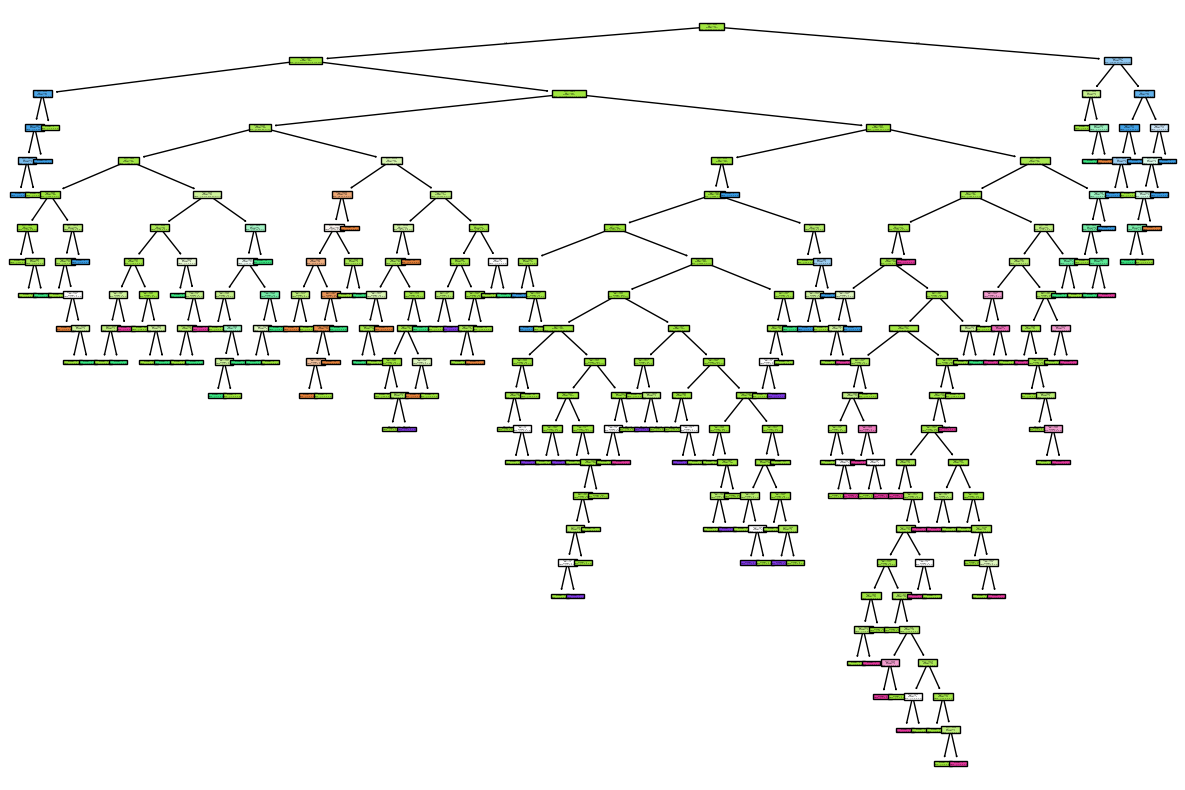

In [ ]:
plt.figure(figsize=(15,10))
tree.plot_tree(decision_tree,filled=True)

# It can be seen that overfitting is caused due to formation of very complex tree.

In [55]:
path = decision_tree.cost_complexity_pruning_path(X_train,y_train)
ccp_alphas,impurities = path.ccp_alphas,path.impurities
ccp_alphas

array([0.00000000e+00, 5.71287895e-05, 8.54458694e-05, 8.92219728e-05,
       1.07142857e-04, 1.23809524e-04, 1.28571429e-04, 1.31868132e-04,
       1.34768428e-04, 1.36054422e-04, 1.37142857e-04, 1.38095238e-04,
       1.39225182e-04, 1.39455782e-04, 1.40435835e-04, 1.42610837e-04,
       1.46884055e-04, 1.67281106e-04, 1.75862614e-04, 1.78559367e-04,
       1.78571429e-04, 1.78571429e-04, 1.90041199e-04, 1.90476190e-04,
       1.90476190e-04, 1.90476190e-04, 1.90476190e-04, 1.90476190e-04,
       1.90476190e-04, 1.94581385e-04, 2.14285714e-04, 2.14285714e-04,
       2.14285714e-04, 2.28571429e-04, 2.32142857e-04, 2.38080984e-04,
       2.43506494e-04, 2.46467818e-04, 2.47371676e-04, 2.50000000e-04,
       2.53968254e-04, 2.54007019e-04, 2.60461760e-04, 2.63736264e-04,
       2.66666667e-04, 2.71211275e-04, 2.83549784e-04, 3.04241503e-04,
       3.09090909e-04, 3.29670330e-04, 3.64285714e-04, 3.70748299e-04,
       3.79027604e-04, 3.96274912e-04, 3.98874459e-04, 4.09297052e-04,
      

In [56]:
# Fit decision tree for each ccp_alpha

dts = []
for ccp_alpha in ccp_alphas:
    decision_tree=DecisionTreeClassifier(random_state=1,ccp_alpha=ccp_alpha)
    decision_tree.fit(X_train,y_train)
    dts.append(decision_tree)
# print("Number of ")

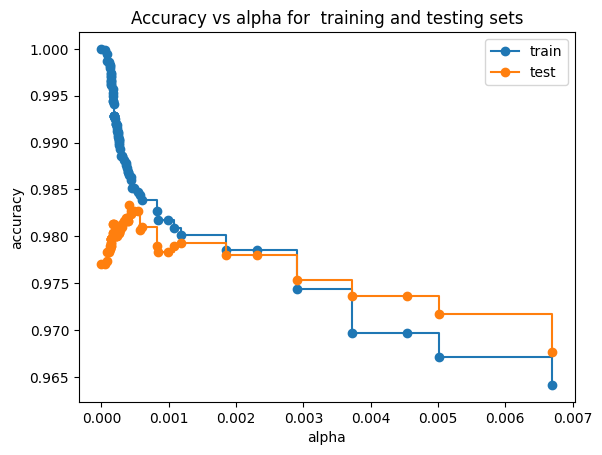

In [ ]:
# calulate and plot the accuracy over training and testing dataset for each fitted decision tree
# find the optimal ccp_alpha from the plot

train_scores = [decision_tree.score(X_train,y_train) for decision_tree in dts]
test_scores = [decision_tree.score(X_test,y_test) for decision_tree in dts]

fig,ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for  training and testing sets")
ax.plot(ccp_alphas, train_scores,marker="o",label="train",drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores,marker="o",label="test",drawstyle="steps-post")
plt.legend()
plt.show()

In [ ]:
# Selected optimal value of 0.0015 of ccp_alpha
# It can be observed that overfitting decreased.

decision_tree = DecisionTreeClassifier(random_state=1,ccp_alpha=0.0015)
decision_tree.fit(X_train,y_train)
y_pred_dt = decision_tree.predict(X_test)

dt_train_accuracy = round(decision_tree.score(X_train, y_train) * 100, 2)
dt_test_accuracy = round(accuracy_score(y_test,y_pred_dt) * 100, 2)

print("Training Accuracy :",dt_train_accuracy ,"%")
print("Model Accuracy Score :",dt_test_accuracy ,"%")


Training Accuracy : 98.01 %
Model Accuracy Score : 97.93 %


[Text(0.5555555555555556, 0.9375, 'x[3] <= 64.95\ngini = 0.07\nsamples = 7000\nvalue = [89, 6749, 56, 64, 11, 31]'),
 Text(0.4444444444444444, 0.8125, 'x[3] <= 13.15\ngini = 0.06\nsamples = 6955\nvalue = [86.0, 6741.0, 51.0, 35.0, 11.0, 31.0]'),
 Text(0.5, 0.875, 'True  '),
 Text(0.3333333333333333, 0.6875, 'gini = 0.165\nsamples = 22\nvalue = [0, 2, 0, 20, 0, 0]'),
 Text(0.5555555555555556, 0.6875, 'x[2] <= 1380.5\ngini = 0.055\nsamples = 6933\nvalue = [86.0, 6739.0, 51.0, 15.0, 11.0, 31.0]'),
 Text(0.4444444444444444, 0.5625, 'x[0] <= 301.55\ngini = 0.252\nsamples = 936\nvalue = [86, 804, 38, 4, 2, 2]'),
 Text(0.2222222222222222, 0.4375, 'x[4] <= 188.5\ngini = 0.107\nsamples = 698\nvalue = [2, 659, 31, 4, 0, 2]'),
 Text(0.1111111111111111, 0.3125, 'gini = 0.026\nsamples = 606\nvalue = [2, 598, 2, 4, 0, 0]'),
 Text(0.3333333333333333, 0.3125, 'x[3] <= 53.75\ngini = 0.461\nsamples = 92\nvalue = [0.0, 61.0, 29.0, 0.0, 0.0, 2.0]'),
 Text(0.2222222222222222, 0.1875, 'gini = 0.229\nsamples

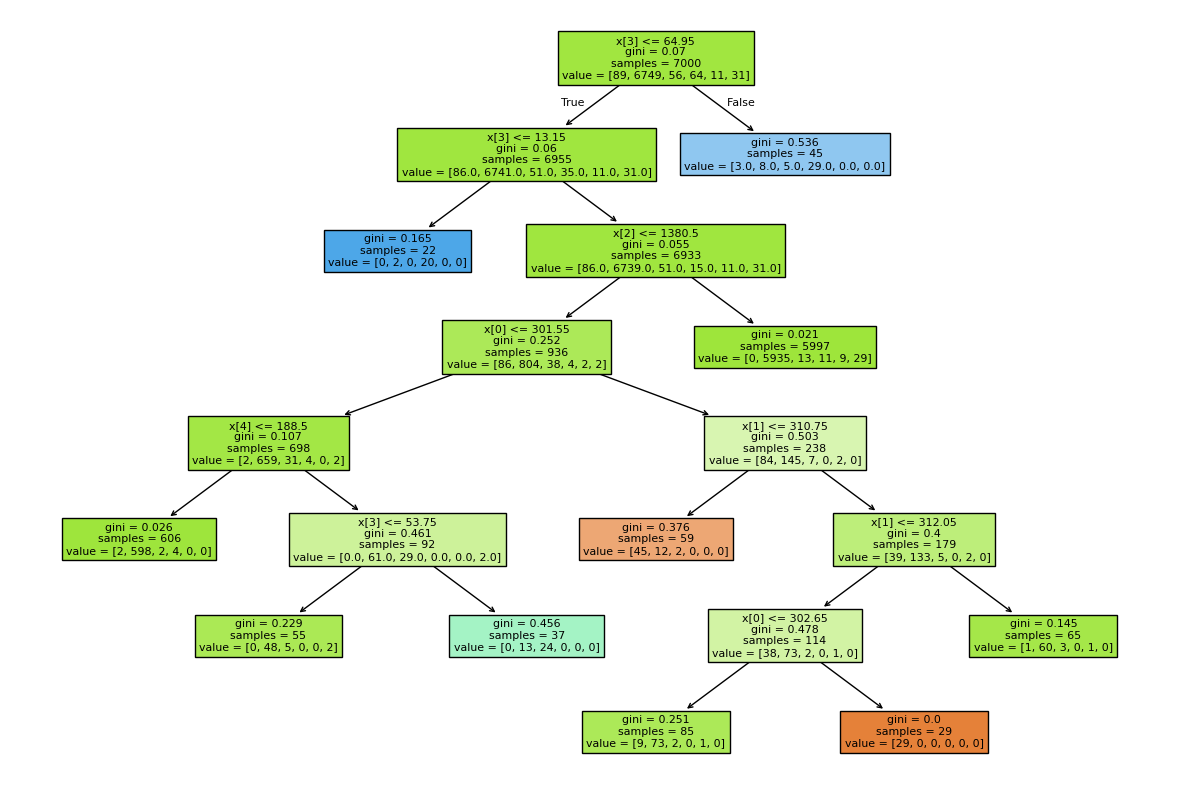

In [59]:
plt.figure(figsize=(15,10))
tree.plot_tree(decision_tree,filled=True)

### Hyperparameter tuning using GridSearchCV
Don't run this section again and again, run once and store the results in a session and access later

In [81]:
start = time.time()
# Define model parameters
model_params = {
    'dt':{'model':DecisionTreeClassifier(criterion='gini',random_state=1,ccp_alpha=0.0012),
          'params':{'max_depth':[5,6,7,8,10,20,30,50],'min_samples_split':[50,100,200],'min_samples_leaf':[50,100,200]}
          },
    'svc': {'model': SVC(gamma='auto',random_state=1),
        'params': {'C': [1, 10, 20], 'kernel': ['rbf']}
            },
    'random_forest': {'model': RandomForestClassifier(criterion='gini',random_state=1),
        'params': {'n_estimators': [10, 50, 100],'max_depth':[8,10,20,30,50],'min_samples_split':[50,100,200],'min_samples_leaf':[50,100,200]}
            },
    'logistic_regression': {'model': LogisticRegression(penalty='l2',random_state=1),
        'params': {'C': [1, 5, 10]}
            }
}

# Perform grid search and store results
scores_multi = []
for model_name, mp in model_params.items():
    print(model_name)
    print(mp)
    classifier = GridSearchCV(mp['model'], mp['params'], cv=10, return_train_score=True)
    classifier.fit(X.values, y.values)
    scores_multi.append({
        'model': model_name,
        'best_score': classifier.best_score_,
        'best_params': classifier.best_params_,
        'mean_train_score': np.mean(classifier.cv_results_['mean_train_score']),
            })
    print(scores_multi)

# Create DataFrame from scores
df = pd.DataFrame(scores_multi, columns=['model', 'best_score', 'best_params', 'mean_train_score'])

# Print the results
df

end = time.time()

print(f"Time taken {(end-start)/60} mins")


dt
{'model': DecisionTreeClassifier(ccp_alpha=0.0012, random_state=1), 'params': {'max_depth': [5, 6, 7, 8, 10, 20, 30, 50], 'min_samples_split': [50, 100, 200], 'min_samples_leaf': [50, 100, 200]}}
[{'model': 'dt', 'best_score': np.float64(0.9692000000000001), 'best_params': {'max_depth': 7, 'min_samples_leaf': 50, 'min_samples_split': 50}, 'mean_train_score': np.float64(0.9687966049382715)}]
svc
{'model': SVC(gamma='auto', random_state=1), 'params': {'C': [1, 10, 20], 'kernel': ['rbf']}}
[{'model': 'dt', 'best_score': np.float64(0.9692000000000001), 'best_params': {'max_depth': 7, 'min_samples_leaf': 50, 'min_samples_split': 50}, 'mean_train_score': np.float64(0.9687966049382715)}, {'model': 'svc', 'best_score': np.float64(0.9652), 'best_params': {'C': 1, 'kernel': 'rbf'}, 'mean_train_score': np.float64(0.9988407407407407)}]
random_forest
{'model': RandomForestClassifier(random_state=1), 'params': {'n_estimators': [10, 50, 100], 'max_depth': [8, 10, 20, 30, 50], 'min_samples_split': 

c:\Users\subhi\anaconda3\envs\torchenv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\subhi\anaconda3\envs\torchenv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

[{'model': 'dt', 'best_score': np.float64(0.9692000000000001), 'best_params': {'max_depth': 7, 'min_samples_leaf': 50, 'min_samples_split': 50}, 'mean_train_score': np.float64(0.9687966049382715)}, {'model': 'svc', 'best_score': np.float64(0.9652), 'best_params': {'C': 1, 'kernel': 'rbf'}, 'mean_train_score': np.float64(0.9988407407407407)}, {'model': 'random_forest', 'best_score': np.float64(0.9658), 'best_params': {'max_depth': 8, 'min_samples_leaf': 50, 'min_samples_split': 50, 'n_estimators': 10}, 'mean_train_score': np.float64(0.9654180246913581)}, {'model': 'logistic_regression', 'best_score': np.float64(0.9663999999999999), 'best_params': {'C': 5}, 'mean_train_score': np.float64(0.9661407407407406)}]
Time taken 53.90653584798177 mins


c:\Users\subhi\anaconda3\envs\torchenv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [84]:
print(f"Time taken {(end-start)/60} mins")

Time taken 53.90653584798177 mins


In [82]:
%store scores_multi

Stored 'scores_multi' (list)


### Run GridSearchCV for hyperparameter tuning for each above classifier; cache results to avoid re-computation

In [60]:
%store -r scores_multi

In [61]:
scores_multi[0]['best_params']

{'max_depth': 7, 'min_samples_leaf': 50, 'min_samples_split': 50}

In [62]:
scores_multi[2]['best_params']['n_estimators'],

(10,)

### Instantiate classifiers using optimal hyperparameters selected via GridSearchCV

In [64]:
dt_multi_clf = DecisionTreeClassifier(criterion='gini', ccp_alpha=0.0015, random_state=1, 
                                      max_depth=scores_multi[0]['best_params']['max_depth'],
                                      min_samples_leaf=scores_multi[0]['best_params']['min_samples_leaf'],
                                      min_samples_split=scores_multi[0]['best_params']['min_samples_split'],
                                      class_weight="balanced")

svc_multi_clf = SVC(gamma='auto', random_state=1, C=scores_multi[1]['best_params']['C'], 
                    kernel=scores_multi[1]['best_params']['kernel'], class_weight="balanced")

rf_multi_clf = RandomForestClassifier(criterion='gini', random_state=1, 
                                      max_depth=scores_multi[2]['best_params']['max_depth'],
                                      n_estimators=scores_multi[2]['best_params']['n_estimators'],
                                      min_samples_leaf=scores_multi[2]['best_params']['min_samples_leaf'],
                                      min_samples_split=scores_multi[2]['best_params']['min_samples_split'],
                                      class_weight="balanced")

lr_multi_clf = LogisticRegression(penalty='l2', random_state=1, C=scores_multi[3]['best_params']['C'],
                                  max_iter=150, class_weight="balanced")

### Using Stratified K-Fold Cross Validation for evaluating the models after initializing them with best hyperparameters chosen set

In [65]:
def get_score(model,stratified_kfold):
    cv_results = cross_validate(model, X, y, cv=stratified_kfold, return_train_score=True)

    print("****" * 4)
    print(model)
    print('Train Scores:', cv_results['train_score'])
    print('Test Scores:', cv_results['test_score'])
    print('Average Train Accuracy:', np.mean(cv_results['train_score']))
    print('Average Test Accuracy:', np.mean(cv_results['test_score']))
    print("****" * 4)

models=[svc_multi_clf,lr_multi_clf,dt_multi_clf,rf_multi_clf]
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
for model in models:
    get_score(model,stratified_kfold)

****************
SVC(C=1, class_weight='balanced', gamma='auto', random_state=1)
Train Scores: [0.99977778 0.99955556 0.99966667 0.99955556 0.99966667 0.99966667
 0.99955556 0.99966667 0.99966667 0.99955556]
Test Scores: [0.964 0.966 0.965 0.965 0.965 0.965 0.965 0.965 0.963 0.965]
Average Train Accuracy: 0.9996333333333334
Average Test Accuracy: 0.9648
****************


c:\Users\subhi\anaconda3\envs\torchenv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\subhi\anaconda3\envs\torchenv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

****************
LogisticRegression(C=5, class_weight='balanced', max_iter=150, random_state=1)
Train Scores: [0.61488889 0.52311111 0.57144444 0.551      0.58166667 0.56577778
 0.53144444 0.525      0.50833333 0.525     ]
Test Scores: [0.648 0.527 0.556 0.546 0.582 0.583 0.532 0.515 0.508 0.506]
Average Train Accuracy: 0.5497666666666667
Average Test Accuracy: 0.5503000000000001
****************
****************
DecisionTreeClassifier(ccp_alpha=0.0015, class_weight='balanced', max_depth=7,
                       min_samples_leaf=50, min_samples_split=50,
                       random_state=1)
Train Scores: [0.52022222 0.55122222 0.53177778 0.58022222 0.60722222 0.47488889
 0.63322222 0.50788889 0.71466667 0.51455556]
Test Scores: [0.519 0.552 0.492 0.588 0.592 0.475 0.63  0.515 0.695 0.512]
Average Train Accuracy: 0.5635888888888889
Average Test Accuracy: 0.557
****************
****************
RandomForestClassifier(class_weight='balanced', max_depth=8,
                       min_sam

### Gradient boosted classifiers: XGBoost

#### Fit and evaluate Xgboost with default/random hyperparameters

In [ ]:
xgboost_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, 
                                         max_depth=1, random_state=0).fit(X_train, y_train)
xgboost_clf.score(X_test, y_test)

0.9056666666666666

In [66]:
# xgboost_clf = GradientBoostingClassifier(n_estimators=100, 
#                                          learning_rate=0.05, 
#                                          max_depth=10, random_state=1).fit(X_train, y_train)
# xgboost_clf.score(X_test, y_test)

#### Fine tune Xgboost classifier

In [55]:
# Define model parameters
model_params = {
    'xgboost':{'model':GradientBoostingClassifier(random_state=1),
          'params':{'max_depth':[1,5,10,50],'n_estimators':[10,50,100],'learning_rate':[0.01,0.05,0.1,1]}
          }
}

# Perform grid search and store results
scores_bnry_xgboost = []
for model_name, mp in model_params.items():
    print(model_name)
    print("Parameters",mp)
    classifier = GridSearchCV(mp['model'], mp['params'], cv=10, return_train_score=True) #this will create a GridSearchCV object
    classifier.fit(X.values, y.values) #This will fit the GridSearchCV on the whole data, but during fitting cross-validation will be 
                                       #performed on the training data to tune the hyperparameters and select the best model.
    scores_bnry_xgboost.append({
        'model': model_name,
        'best_score': classifier.best_score_,
        'best_params': classifier.best_params_,
        'mean_train_score': np.mean(classifier.cv_results_['mean_train_score']),
            })
    print(scores_bnry_xgboost)

# Create DataFrame from scores
df_xgboost = pd.DataFrame(scores_bnry_xgboost, columns=['model', 'best_score', 'best_params', 'mean_train_score'])

# Print the results
df_xgboost


xgboost
Parameters {'model': GradientBoostingClassifier(random_state=1), 'params': {'max_depth': [1, 5, 10, 50], 'n_estimators': [10, 50, 100], 'learning_rate': [0.01, 0.05, 0.1, 1]}}
[{'model': 'xgboost', 'best_score': 0.9780000000000001, 'best_params': {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}, 'mean_train_score': 0.9274002314814815}]


,model,best_score,best_params,mean_train_score
0,xgboost,0.978,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",0.9274


In [56]:
scores_multi_xgboost=scores_bnry_xgboost

In [57]:
%store scores_multi_xgboost

Stored 'scores_multi_xgboost' (list)


In [58]:
%store -r scores_multi_xgboost

#### Initialize the model with best hyperparamters

In [67]:
%store -r scores_multi_xgboost

In [68]:
scores_multi_xgboost[0]['best_params']

{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}

In [69]:
xgboost_multi_clf = GradientBoostingClassifier(random_state=1, max_depth=scores_multi_xgboost[0]['best_params']['max_depth'],
                                              learning_rate=scores_multi_xgboost[0]['best_params']['learning_rate'],
                                              n_estimators=scores_multi_xgboost[0]['best_params']['n_estimators'])

#### Model evaluation using stratified-kfold technique

In [70]:
def get_score(model,stratified_kfold):
    cv_results = cross_validate(model, X, y, cv=stratified_kfold, return_train_score=True)

    print("****" * 4)
    print(model)
    print('Train Scores:', cv_results['train_score'])
    print('Test Scores:', cv_results['test_score'])
    print('Average Train Accuracy:', np.mean(cv_results['train_score']))
    print('Average Test Accuracy:', np.mean(cv_results['test_score']))
    print("****" * 4)

models=[xgboost_multi_clf]
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
for model in models:
    get_score(model,stratified_kfold)

****************
GradientBoostingClassifier(learning_rate=0.01, max_depth=5, random_state=1)
Train Scores: [0.99211111 0.99088889 0.99133333 0.99066667 0.99144444 0.99044444
 0.99144444 0.99166667 0.99166667 0.99144444]
Test Scores: [0.982 0.983 0.983 0.987 0.982 0.977 0.984 0.981 0.983 0.984]
Average Train Accuracy: 0.9913111111111113
Average Test Accuracy: 0.9826
****************


In [62]:
xgboost_multi_clf

GradientBoostingClassifier(learning_rate=0.01, max_depth=5, random_state=1)

#### Fitting and evaluating the model

In [90]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))

# Assign weights to each sample manually
sample_weights = np.array([class_weight_dict[label] for label in y_train])



In [91]:
xgboost_multi_clf.fit(X_train,y_train, sample_weight=sample_weights)

GradientBoostingClassifier(learning_rate=0.01, max_depth=5, random_state=1)

In [92]:
y_pred=xgboost_multi_clf.predict(X_test)
print(np.unique(y_pred))
y_pred_df = pd.DataFrame({'Predicted': y_pred})

# Convert X_test to a DataFrame
X_test_df = pd.DataFrame(X_test)  # Assuming X_test is a DataFrame

#X_test_df.info()
#y_pred_df.info()

# Concatenate y_pred_df and X_test_df along the columns
X_test_df.reset_index(drop=True, inplace=True)
y_pred_df.reset_index(drop=True, inplace=True)
result_df = pd.concat([X_test_df, y_pred_df], axis=1)
result_df["Predicted"].unique()


[0 1 2 3 4 5]


array([1, 5, 2, 4, 0, 3])

In [93]:
confusion_matrix(y_test, y_pred)

array([[  22,    1,    0,    0,    0,    0],
       [  26, 2411,   43,   13,  257,  153],
       [   1,    2,   17,    0,    0,    2],
       [   0,    7,    0,   24,    0,    0],
       [   0,    5,    0,    0,    1,    1],
       [   1,    3,    0,    0,    0,   10]])

In [94]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.44      0.96      0.60        23
           1       0.99      0.83      0.90      2903
           2       0.28      0.77      0.41        22
           3       0.65      0.77      0.71        31
           4       0.00      0.14      0.01         7
           5       0.06      0.71      0.11        14

    accuracy                           0.83      3000
   macro avg       0.40      0.70      0.46      3000
weighted avg       0.97      0.83      0.89      3000



### Evaluate all classifiers using classification measures

#### Random Forest

In [75]:
rf_multi_clf.fit(X_train,y_train)
y_pred = rf_multi_clf.predict(X_test)
np.unique(y_pred)

array([0, 1, 2, 3, 4, 5])

In [76]:
confusion_matrix(y_test, y_pred)

array([[  20,    0,    1,    0,    0,    2],
       [  35, 2538,   52,   44,   48,  186],
       [   1,    0,   19,    1,    0,    1],
       [   2,    1,    3,   25,    0,    0],
       [   0,    5,    0,    0,    1,    1],
       [   0,    1,    2,    0,    0,   11]])

In [77]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.34      0.87      0.49        23
           1       1.00      0.87      0.93      2903
           2       0.25      0.86      0.38        22
           3       0.36      0.81      0.50        31
           4       0.02      0.14      0.04         7
           5       0.05      0.79      0.10        14

    accuracy                           0.87      3000
   macro avg       0.34      0.72      0.41      3000
weighted avg       0.97      0.87      0.91      3000



#### Decision Tree

In [79]:
dt_multi_clf.fit(X_train,y_train)
y_pred = dt_multi_clf.predict(X_test)
np.unique(y_pred)

array([0, 1, 2, 3, 4, 5])

In [78]:
confusion_matrix(y_test, y_pred)

array([[  20,    0,    1,    0,    0,    2],
       [  35, 2538,   52,   44,   48,  186],
       [   1,    0,   19,    1,    0,    1],
       [   2,    1,    3,   25,    0,    0],
       [   0,    5,    0,    0,    1,    1],
       [   0,    1,    2,    0,    0,   11]])

In [80]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.26      0.70      0.38        23
           1       1.00      0.71      0.83      2903
           2       0.24      0.82      0.37        22
           3       0.47      0.90      0.62        31
           4       0.00      0.14      0.00         7
           5       0.05      0.93      0.10        14

    accuracy                           0.72      3000
   macro avg       0.34      0.70      0.38      3000
weighted avg       0.97      0.72      0.82      3000



#### SVC

In [81]:
svc_multi_clf.fit(X_train,y_train)
y_pred = svc_multi_clf.predict(X_test)
np.unique(y_pred)

array([0, 1])

In [82]:
confusion_matrix(y_test, y_pred)

array([[   0,   23,    0,    0,    0,    0],
       [   1, 2902,    0,    0,    0,    0],
       [   0,   22,    0,    0,    0,    0],
       [   0,   31,    0,    0,    0,    0],
       [   0,    7,    0,    0,    0,    0],
       [   0,   14,    0,    0,    0,    0]])

In [83]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.97      1.00      0.98      2903
           2       0.00      0.00      0.00        22
           3       0.00      0.00      0.00        31
           4       0.00      0.00      0.00         7
           5       0.00      0.00      0.00        14

    accuracy                           0.97      3000
   macro avg       0.16      0.17      0.16      3000
weighted avg       0.94      0.97      0.95      3000



c:\Users\subhi\anaconda3\envs\torchenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\subhi\anaconda3\envs\torchenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\subhi\anaconda3\envs\torchenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

#### Logistic Regression

In [87]:
lr_multi_clf.fit(X_train,y_train)
y_pred = lr_multi_clf.predict(X_test)
np.unique(y_pred)

c:\Users\subhi\anaconda3\envs\torchenv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([0, 1, 2, 3, 4, 5])

In [85]:
np.unique(y_pred)

array([0, 1, 2, 3, 4, 5])

In [88]:
confusion_matrix(y_test, y_pred)

array([[  18,    0,    1,    1,    3,    0],
       [ 334, 1607,   70,   54,  634,  204],
       [   2,    0,   14,    2,    0,    4],
       [   0,    0,    0,   31,    0,    0],
       [   0,    5,    0,    1,    0,    1],
       [   0,    0,    3,    0,    0,   11]])

In [89]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.05      0.78      0.10        23
           1       1.00      0.55      0.71      2903
           2       0.16      0.64      0.25        22
           3       0.35      1.00      0.52        31
           4       0.00      0.00      0.00         7
           5       0.05      0.79      0.09        14

    accuracy                           0.56      3000
   macro avg       0.27      0.63      0.28      3000
weighted avg       0.97      0.56      0.70      3000



### Dump the trained classifiers in a pickle file

In [104]:
pickle_out=open("rf_multi_clf.pkl","wb")
pickle.dump(rf_multi_clf,pickle_out)
pickle_out.close()

In [105]:
pickle_out=open("dt_multi_clf.pkl","wb")
pickle.dump(dt_multi_clf,pickle_out)
pickle_out.close()

In [106]:
pickle_out=open("lr_multi_clf.pkl","wb") # opening a filename with write byte mode
pickle.dump(lr_multi_clf,pickle_out) #dumping the classifier inside the file
pickle_out.close() #close the pickle file

In [20]:
# Pickle the label encoder
with open("label_encoder.pkl", "wb") as label_encoder_file:
    pickle.dump(scaler, label_encoder_file)

In [131]:
test_data=pd.read_csv('TestFile.csv')
test_data

,AirTemperature,ProcessTemperature,RotationalSpeed,Torque,ToolWear
0,300.0,300.0,1500,40.0,30
1,290.0,290.0,1400,39.0,29
2,298.9,309.1,2861,4.6,143
3,98.9,309.0,1410,65.7,191
4,305.0,200.0,150,15.0,1
5,285.0,200.0,1400,40.0,25
6,300.5,309.9,1397,45.9,210
7,300.3,311.7,1545,43.5,160


In [132]:
prediction=lr_multi_clf.predict(test_data)

In [133]:
prediction

array([4, 4, 3, 3, 0, 3, 5, 1])

In [134]:
prediction=dt_multi_clf.predict(test_data)
prediction

array([1, 1, 3, 2, 0, 1, 5, 1])

In [135]:
prediction=rf_multi_clf.predict(test_data)
prediction

array([1, 1, 3, 2, 0, 1, 5, 1])